<a href="https://colab.research.google.com/github/nityam0703/SpamClassifier/blob/main/SpamNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
df=pd.read_csv('spamclf.csv')
df.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [18]:
df.shape

(3000, 2)

In [19]:
df['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

In [20]:
df.columns

Index(['email', 'label'], dtype='object')

In [21]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []

In [22]:
for i in range(0, len(df)):
    str1 = str(df['email'][i])
    review = re.sub('[^a-zA-Z]', ' ', str1)
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tdf = TfidfVectorizer(max_features=15000)
X=tdf.fit_transform(corpus).toarray()

In [28]:
X.shape

(3000, 15000)

In [33]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
y=df['label']

In [34]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: label, Length: 3000, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7,stratify = y)

In [38]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.6 MB/s eta 0:00:00


In [51]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
import kerastuner as kt
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [52]:
def build_model(hp):
    model = Sequential()
    counter=0
    for i in range(hp.Int('num_layers',min_value=100,max_value=1000)):
        if counter==0 :
            model.add(Dense(hp.Int('units'+str(i),min_value=100,max_value=1000,step=50),activation=hp.Choice('activation' + str(i),values=['relu','tanh','sigmoid']),input_dim=15000))
            model.add(Dropout(hp.Choice('drp'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else :
            model.add(Dense(hp.Int('units'+str(i),min_value=100,max_value=1000,step=50),activation=hp.Choice('activation' + str(i),values=['relu','tanh','sigmoid'])))
            model.add(Dropout(hp.Choice('drp'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
            counter+=1
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer=hp.Choice('optimizer',values=['rmsprop','adam','sgd','nadam']),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [53]:
tuner=kt.RandomSearch(build_model,objective='val_accuracy',max_trials=50)

In [54]:
tuner.search(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Trial 50 Complete [00h 00m 06s]
val_accuracy: 0.971666693687439

Best val_accuracy So Far: 0.9883333444595337
Total elapsed time: 00h 04m 43s


In [57]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 2,
 'units0': 20,
 'activation0': 'tanh',
 'drp0': 0.2,
 'optimizer': 'nadam',
 'units1': 20,
 'activation1': 'tanh',
 'drp1': 0.5,
 'units2': 32,
 'activation2': 'relu',
 'drp2': 0.8,
 'units3': 16,
 'activation3': 'relu',
 'drp3': 0.2,
 'units4': 20,
 'activation4': 'relu',
 'drp4': 0.2,
 'units5': 8,
 'activation5': 'tanh',
 'drp5': 0.2}

In [58]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                300020    
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 300,461
Trainable params: 300,461
Non-trainable params: 0
_________________________________________________________________


In [59]:
callback=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True)

In [60]:
history = model.fit(X_train,y_train,epochs=500,initial_epoch=5,validation_data=(X_test,y_test),callbacks=callback)

Epoch 6/500
75/75 [==============================] - 2s 12ms/step - loss: 0.0110 - accuracy: 0.9979 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 7/500
75/75 [==============================] - 1s 14ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0290 - val_accuracy: 0.9900
Epoch 8/500
75/75 [==============================] - 1s 14ms/step - loss: 0.0061 - accuracy: 0.9987 - val_loss: 0.0274 - val_accuracy: 0.9900
Epoch 9/500
75/75 [==============================] - 1s 9ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0268 - val_accuracy: 0.9900
Epoch 10/500
75/75 [==============================] - 1s 9ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0261 - val_accuracy: 0.9933
Epoch 11/500
75/75 [==============================] - 1s 9ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0250 - val_accuracy: 0.9933
Epoch 12/500
75/75 [==============================] - 1s 9ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9917
Epoch 1

In [61]:
y_rec = model.predict(X_test)

19/19 [==============================] - 0s 3ms/step


In [62]:
y_pred = np.where(y_rec>=0.5,1,0)

In [64]:
import matplotlib.pyplot as plt

In [69]:
from sklearn.metrics import accuracy_score,f1_score,classification_report
score_ann=accuracy_score(y_test,y_pred)
score_ann

0.9933333333333333

In [70]:
f1_ann=f1_score(y_pred,y_test)
f1_ann

0.9797979797979798

In [71]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       500
           1       0.99      0.97      0.98       100

    accuracy                           0.99       600
   macro avg       0.99      0.98      0.99       600
weighted avg       0.99      0.99      0.99       600



Text(50.722222222222214, 0.5, 'True')

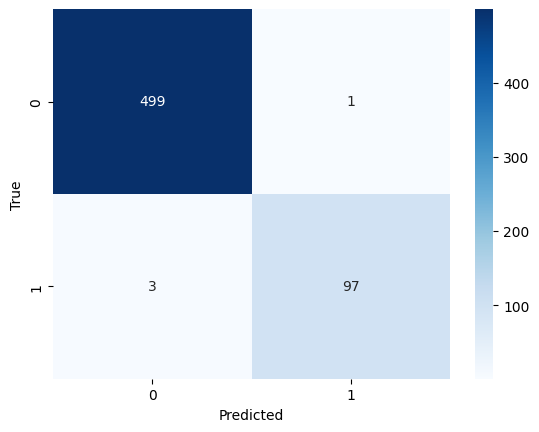

In [73]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')